In [6]:
#%pip install -U langchain-core
#%pip install langchain
%pip install grandalf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
# Replace this with your actual Gemini API key
api_key = ""

# Initialize Gemini 1.5 model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",   # or "gemini-1.5-pro"
    google_api_key=api_key,
    temperature=0.7
)


In [9]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
            " Generate the best twitter post possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet."
            "Always provide detailed recommendations, including requests for length, virality, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

generation_chain = generation_prompt | llm
reflection_chain = reflection_prompt | llm

In [10]:
from typing import List, Sequence
#from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
#from chains import generation_chain, reflection_chain

#load_dotenv()

REFLECT = "reflect"
GENERATE = "generate"
graph = MessageGraph()

def generate_node(state):
    return generation_chain.invoke({
        "messages": state
    })


def reflect_node(messages):
    response = reflection_chain.invoke({
        "messages": messages
    })
    return [HumanMessage(content=response.content)]


graph.add_node(GENERATE, generate_node)
graph.add_node(REFLECT, reflect_node)
graph.set_entry_point(GENERATE)


def should_continue(state):
    if (len(state) > 6):
        return END 
    return REFLECT


graph.add_conditional_edges(GENERATE, should_continue)
graph.add_edge(REFLECT, GENERATE)

app = graph.compile()

print(app.get_graph().draw_mermaid())
app.get_graph().print_ascii()

dot = graph.get_graph().draw()
display(dot)

response = app.invoke(HumanMessage(content="AI Agents taking over content creation"))

print(response)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	generate(generate)
	reflect(reflect)
	__end__(<p>__end__</p>)
	__start__ --> generate;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
+----------+   
| generate |   
+----------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


AttributeError: 'MessageGraph' object has no attribute 'get_graph'

#FLIGHT AGENT BUIDING

In [ ]:
from langchain.tools import tool
import requests
import json

from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI


# Replace this with your actual Gemini API key
api_key = ""
serp_api_key = ""

# Initialize Gemini 1.5 model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",   # or "gemini-1.5-pro"
    google_api_key=api_key,
    temperature=0.7
)



@tool
def getAllFlights(engine: str, departure_id: str, arrival_id: str, outbound_date: str, return_date: str, serp_api_key: str) -> str:
    """
    Search and return flight options using Google Flights via SerpAPI.

    Args:
        engine: Use 'google_flights' for Google Flights search.
        departure_id: IATA code of the departure airport (e.g., 'BLR' for Bangalore).
        arrival_id: IATA code of the arrival airport (e.g., 'DEL' for Delhi).
        outbound_date: Outbound flight date in YYYY-MM-DD format.
        return_date: Return flight date in YYYY-MM-DD format.
        serp_api_key: Your SerpAPI API key.

    Returns:
        A list of flight options with airline name, route, departure/arrival time, and price.
    """

    missing = []
    if not engine: missing.append("engine")
    if not departure_id: missing.append("departure_id")
    if not arrival_id: missing.append("arrival_id")
    if not outbound_date: missing.append("outbound_date")
    if not return_date: missing.append("return_date")
    if not serp_api_key: missing.append("serp_api_key")

    if missing:
        return f"❌ Missing required parameters: {', '.join(missing)}"

    try:
        params = {
            "engine": "google_flights",
            "departure_id": departure_id,
            "arrival_id": arrival_id,
            "outbound_date": outbound_date,
            "return_date": return_date,
            "hl": "en",
            "api_key": serp_api_key
        }

        response = requests.get("https://serpapi.com/search", params=params)
        data = response.json()

        JSON_DATA = json.dumps(data, indent=2)

        # print(JSON_DATA)

        # Example structure from SerpAPI response
        flights = data.get("flights_results", [])
        if not flights:
            return "❌ No flights found for the given query."

        result = []
        for flight in flights[:5]:  # Return top 5 results
            segments = flight.get("segments", [])
            for segment in segments:
                airline = segment.get("airline", {}).get("name", "Unknown Airline")
                from_airport = segment.get("departure_airport", {}).get("name", "")
                to_airport = segment.get("arrival_airport", {}).get("name", "")
                dep_time = segment.get("departure_time", "")
                arr_time = segment.get("arrival_time", "")
                price = flight.get("price", "N/A")

                result.append(f"{airline}: {from_airport} ➡ {to_airport} | Dep: {dep_time} | Arr: {arr_time} | Price: {price}")

        return "\n".join(result)

    except Exception as e:
        return f"❌ Error fetching flight data: {str(e)}"


tools = [getAllFlights]
tool_map = {tool.name: tool for tool in tools}

llm_with_tools = llm.bind_tools(tools=tools)

llm_with_tools

In [ ]:
from datetime import datetime

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

def agent(state: ChildState) -> ChildState:
    print(state["messages"])
    cleaned_messages = [msg for msg in state["messages"] if getattr(msg, "content", "").strip()]
    print(cleaned_messages)

    # for i, msg in enumerate(cleaned_messages):
    #     print(f"[{i}] {type(msg).__name__}: {msg.content}")
    
    print("AGAIIN ?? \n")
    
    response = llm_with_tools.invoke(cleaned_messages)
    return {"messages": [response]}

def is_past(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d").date() < datetime.today().date()

def call_tools(state: ChildState) -> ChildState:
    tool_calls = state["messages"][-1].tool_calls
    tool_outputs = []


    for call in tool_calls:
        tool = tool_map[call["name"]]
        args = call["args"]

        required_args = tool.args
        missing = [k for k in required_args if not args.get(k)]
        print(tool.args)

        if "serp_api_key" in tool.args or "serp_api_key" in args:
            args["serp_api_key"] = serp_api_key
        
        if 'outbound_date' in tool.args:
            args['outbound_date'] = '2025-06-23'

        if 'return_date' in tool.args:
            args['return_date'] = '2025-06-25'

        print("outbound date:", args['outbound_date'])
        print("Return date: ", args['return_date'])

        if missing:
            tool_outputs.append(AIMessage(content=f"checking before calling tool... ❌ Missing tool parameters: {', '.join(missing)}"))
            continue

        if is_past(args["outbound_date"]) or is_past(args["return_date"]):
            return {"messages": [AIMessage(content="❌ The flight dates you provided are in the past. Please provide future dates.")]}


        output = tool.invoke(args)
        tool_outputs.append(AIMessage(content=str(output)))

    return {"messages": tool_outputs}

# ---- Router logic ----
def tools_router(state: ChildState) -> str:
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_node"
    else:
        return END
    

subgraph = StateGraph(ChildState)
subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", call_tools)

subgraph.set_entry_point("agent")
subgraph.add_conditional_edges("agent", tools_router, {"tool_node": "tool_node", END: END},)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

In [ ]:
system_message = SystemMessage(
    content=(
        "You are a travel assistant. You have access to a tool that can find real-time flight details. "
        "Always suggest future dates for Outbound Date, preferably at least 2 days from today. "
        "If the user asks to find or book a flight, use the `getAllFlights` tool."
    )
)

# ✅ User prompt asking for flights (in natural language)
user_query = HumanMessage(
    content="I want to fly from BLR to DEL on June 21st and return on June 25th. Show me options."
)

print(system_message.content)
print(user_query.content)

You are a travel assistant. You have access to a tool that can find real-time flight details. Always suggest future dates for Outbound Date, preferably at least 2 days from today. If the user asks to find or book a flight, use the `getAllFlights` tool.
I want to fly from BLR to DEL on June 21st and return on June 25th. Show me options.


In [ ]:

# ✅ Trigger the tool-enabled LLM
response = search_app.invoke({
    "messages": [system_message, user_query]
})

[SystemMessage(content='You are a travel assistant. You have access to a tool that can find real-time flight details. Always suggest future dates for Outbound Date, preferably at least 2 days from today. If the user asks to find or book a flight, use the `getAllFlights` tool.', additional_kwargs={}, response_metadata={}, id='554a1deb-14a3-4ed0-bbf9-9158f1d0f31a'), HumanMessage(content='I want to fly from BLR to DEL on June 21st and return on June 25th. Show me options.', additional_kwargs={}, response_metadata={}, id='687c1258-7461-4d66-88ed-9a3d44d0d822')]
[SystemMessage(content='You are a travel assistant. You have access to a tool that can find real-time flight details. Always suggest future dates for Outbound Date, preferably at least 2 days from today. If the user asks to find or book a flight, use the `getAllFlights` tool.', additional_kwargs={}, response_metadata={}, id='554a1deb-14a3-4ed0-bbf9-9158f1d0f31a'), HumanMessage(content='I want to fly from BLR to DEL on June 21st and 

In [ ]:
# ✅ Output the LLM's response
print(response)


In [ ]:
for msg in response['messages']:
    print("\n🔹", msg.content)


🔹 You are a travel assistant. You have access to a tool that can find real-time flight details. Always suggest future dates for Outbound Date, preferably at least 2 days from today. If the user asks to find or book a flight, use the `getAllFlights` tool.

🔹 I want to fly from BLR to DEL on June 21st and return on June 25th. Show me options.

🔹 

🔹 ❌ No flights found for the given query.

🔹 Please note that June 21st is very close to the current date.  To get more flight options, please consider searching for flights on later dates.  For example, try searching for outbound flights starting from June 23rd or later.


In [ ]:
print(json.dumps(JSON_DATA, indent=2))

""


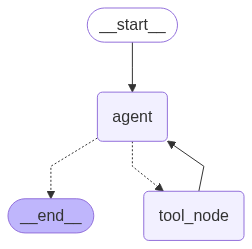

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

#Implementing same with create_react_agent(_)

In [ ]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool

import re
import requests, json
import os


from langchain.tools import tool
import requests
import json

from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Replace with your actual API keys
gemini_api_key = ""
serp_api_key = ""

from langchain.tools import tool
from typing import Annotated

SERP_API_KEY = serp_api_key  # Load from env or config securely

@tool
def getAllFlights_tool(payload: str) -> str:
    """
    Search flights using Google Flights via SerpAPI.
    Input must be a valid JSON string with:
    {
        "engine": "google_flights",
        "departure_id": "BLR",
        "arrival_id": "DEL",
        "outbound_date": "2025-06-21",
        "return_date": "2025-06-25"
    }
    then parse your output to summarizeFlightResults_tool
    """
    try:
        # Step 1: Remove surrounding backticks and code fences if present
        payload_clean = re.sub(r"^`+|`+$|^```json|```$", "", payload.strip(), flags=re.MULTILINE).strip()

        # Step 2: Parse the JSON input
        data = json.loads(payload_clean)

        # Step 3: Add required SerpAPI params
        data["api_key"] = SERP_API_KEY
        data["hl"] = "en"
        data["engine"] = "google_flights"  # force engine to correct value

        # Step 4: Perform request
        response = requests.get("https://serpapi.com/search", params=data)
        res = response.json()

        print(res)

        # Debug: Log full response
        debug_output = f"🔍 Request: {json.dumps(data)}\n\n🧾 Response: {json.dumps(res, indent=2)}\n"

        # Step 5: Parse result
        flights = res.get("best_flights", []) + res.get("other_flights", [])
        if not flights:
            return debug_output + "\n❌ No flights found."

        output = []
        for flight in flights[:5]:
            for segment in flight.get("segments", []):
                airline = segment.get("airline", {}).get("name", "Unknown Airline")
                dep_airport = segment.get("departure_airport", {}).get("name", "")
                arr_airport = segment.get("arrival_airport", {}).get("name", "")
                dep_time = segment.get("departure_time", "")
                arr_time = segment.get("arrival_time", "")
                price = flight.get("price", "N/A")
                output.append(
                    f"{airline}: {dep_airport} ➡ {arr_airport} | Dep: {dep_time} | Arr: {arr_time} | Price: {price}"
                )

        # return debug_output + "\n📍 Flight Options:\n" + "\n".join(output)
        return json.dumps(res)

    except Exception as e:
        return f"❌ Exception occurred inside getAllFlights_tool: {str(e)}"

In [29]:
city_to_iata = {
    "bangalore": "BLR",
    "bengaluru": "BLR",
    "delhi": "DEL",
    "new delhi": "DEL",
    "mumbai": "BOM",
    "hyderabad": "HYD",
    "chennai": "MAA",
    "kolkata": "CCU",
    "goa": "GOI",
    "jaipur": "JAI",
    # add more cities as needed
}

def convert_city_to_iata(city_name: str) -> str:
    city_key = city_name.strip().lower()
    return city_to_iata.get(city_key, city_name.upper())

@tool
def constructFlightSearchPayload_tool(input_text: str) -> str:
    """
    Takes natural language input and returns a JSON string for searching flights.
    Example input: "I want to fly from BLR to DEL on June 21st and return on June 25th."
    """
    try:
        # Use regex or any simple parser (or even an LLM!) for more sophistication
        import re
        from datetime import datetime

        # Basic patterns for matching
        match = re.search(r"from (\w+) to (\w+).*on (\w+ \d+)[a-z]{0,2}.*return on (\w+ \d+)[a-z]{0,2}", input_text, re.IGNORECASE)
        if not match:
            return "❌ Unable to parse input into JSON. Please provide origin, destination, outbound and return dates."

        departure_id = convert_city_to_iata(match.group(1))
        arrival_id = convert_city_to_iata(match.group(2))
        outbound_date = datetime.strptime(match.group(3) + " 2025", "%B %d %Y").strftime("%Y-%m-%d")
        return_date = datetime.strptime(match.group(4) + " 2025", "%B %d %Y").strftime("%Y-%m-%d")

        json_payload = {
            "engine": "google_flights",
            "departure_id": departure_id,
            "arrival_id": arrival_id,
            "outbound_date": outbound_date,
            "return_date": return_date
        }

        return json.dumps(json_payload, indent=2)

    except Exception as e:
        return f"❌ Exception in constructFlightSearchPayload_tool: {str(e)}"

In [30]:
@tool
def summarizeFlightResults_tool(flight_json: str) -> str:
    """
    Summarize the flight results from getAllFlights_tool.
    Input: Raw JSON string response from SerpAPI.
    Output: Nicely formatted flight summaries.
    """
    try:
        data = json.loads(flight_json)
        best = data.get("best_flights", [])
        other = data.get("other_flights", [])

        def format_flights(flights):
            output = []
            for f in flights:
                segments = f.get("segments", [])
                if not segments:
                    continue
                seg = segments[0]
                airline = seg.get("airline", {}).get("name", "Unknown Airline")
                dep_time = seg.get("departure_time", "Unknown")
                arr_time = seg.get("arrival_time", "Unknown")
                dep_airport = seg.get("departure_airport", {}).get("name", "")
                arr_airport = seg.get("arrival_airport", {}).get("name", "")
                price = f.get("price", "N/A")

                # Append dictionary (can be turned into JSON list if needed)
                output.append({
                    "airline": airline,
                    "from": dep_airport,
                    "to": arr_airport,
                    "departure_time": dep_time,
                    "arrival_time": arr_time,
                    "price": price
                })
            return output

        best_formatted = format_flights(best)
        other_formatted = format_flights(other)

        if not best_formatted and not other_formatted:
            return "❌ No flights found in the response."

        # Human-readable formatting (default return)
        summary = []
        if best_formatted:
            summary.append("🔥 Best Flights:\n" + "\n".join(
                [f"{f['airline']}: {f['from']} ➡ {f['to']} | Dep: {f['departure_time']} | Arr: {f['arrival_time']} | Price: {f['price']}" for f in best_formatted]
            ))
        if other_formatted:
            summary.append("✈️ Other Flights:\n" + "\n".join(
                [f"{f['airline']}: {f['from']} ➡ {f['to']} | Dep: {f['departure_time']} | Arr: {f['arrival_time']} | Price: {f['price']}" for f in other_formatted]
            ))

        # return "\n\n".join(summary)

        # 🔁 Optional: If you want structured JSON for UI rendering, use:
        return json.dumps({"best": best_formatted, "others": other_formatted}, indent=2)

    except Exception as e:
        return f"❌ Error parsing flight summary: {str(e)}"


In [ ]:
prompt = PromptTemplate.from_template("""
You are a flight assistant. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (repeat Thought/Action/Action Input/Observation N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
{agent_scratchpad}
""")
# tools = [constructFlightSearchPayload_tool, getAllFlights_tool, summarizeFlightResults_tool]
tools = [get_and_summarize_flights_tool]
### ✅ Step 6: Create agent and executor
agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [ ]:
import re
import json
import requests
from datetime import datetime
from langchain.tools import tool

SERP_API_KEY = serp_api_key  # Replace this with your key

# Simple city-to-IATA code mapping
city_to_iata = {
    "bangalore": "BLR",
    "bengaluru": "BLR",
    "delhi": "DEL",
    "new delhi": "DEL",
    "mumbai": "BOM",
    "hyderabad": "HYD",
    "chennai": "MAA",
    "kolkata": "CCU",
    "goa": "GOI",
    "jaipur": "JAI",
}

def convert_city_to_iata(city_name: str) -> str:
    city_key = city_name.strip().lower()
    return city_to_iata.get(city_key, city_name.upper())

@tool
def get_and_summarize_flights_tool(params: str) -> str:
    # Takes user natural language input for flight search, queries SerpAPI Google Flights, and returns a summarized response.
    # # Example input: "I want to fly from Bangalore to Delhi on June 21st and return on June 25th."

    """
    Take JSON parameters as input and then use SERP API Google Flights, and returns a summarized response

    """
    try:
        # Step 1: Extract info from user input
        # match = re.search(
        #     r"from ([\w\s]+) to ([\w\s]+).*on (\w+ \d+)[a-z]{0,2}.*return on (\w+ \d+)[a-z]{0,2}",
        #     user_input, re.IGNORECASE)
        # if not match:
        #     return "❌ Unable to parse input. Please mention source, destination, outbound date, and return date."

        # from_city = convert_city_to_iata(match.group(1))
        # to_city = convert_city_to_iata(match.group(2))
        # outbound_date = datetime.strptime(match.group(3) + " 2025", "%B %d %Y").strftime("%Y-%m-%d")
        # return_date = datetime.strptime(match.group(4) + " 2025", "%B %d %Y").strftime("%Y-%m-%d")

        # # Step 2: Build request
        # params = {
        #     "engine": "google_flights",
        #     "departure_id": from_city,
        #     "arrival_id": to_city,
        #     "outbound_date": outbound_date,
        #     "return_date": return_date,
        #     "hl": "en",
        #     "api_key": SERP_API_KEY
        # }
        params = {
            **params,
            "api_key": SERP_API_KEY,
        }

        response = requests.get("https://serpapi.com/search", params=params)
        data = response.json()

        best_flights = data.get("best_flights", [])
        other_flights = data.get("other_flights", [])

        def extract_flight_summary(flight_obj):
            segments = flight_obj.get("flights", [])
            if not segments:
                return None
            summary = []
            for seg in segments:
                summary.append({
                    "airline": seg.get("airline", "Unknown"),
                    "flight_number": seg.get("flight_number", ""),
                    "airplane": seg.get("airplane", ""),
                    "from": seg.get("departure_airport", {}).get("name", ""),
                    "to": seg.get("arrival_airport", {}).get("name", ""),
                    "departure_time": seg.get("departure_airport", {}).get("time", ""),
                    "arrival_time": seg.get("arrival_airport", {}).get("time", ""),
                    "duration_minutes": seg.get("duration", ""),
                })
            return {
                "price": flight_obj.get("price", "N/A"),
                "segments": summary,
                "total_duration": flight_obj.get("total_duration", ""),
                "airline_logo": flight_obj.get("airline_logo", "")
            }

        best_summary = [extract_flight_summary(f) for f in best_flights if extract_flight_summary(f)]
        other_summary = [extract_flight_summary(f) for f in other_flights if extract_flight_summary(f)]

        if not best_summary and not other_summary:
            return "❌ No flights found."

        return json.dumps({
            "best": best_summary,
            "others": other_summary
        }, indent=2)

    except Exception as e:
        return f"❌ Exception occurred: {str(e)}"


In [ ]:
from langchain.agents import create_react_agent, AgentExecutor
# from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain.tools import tool

# import re
# import requests, json
# import os


from langchain.tools import tool
import requests
import json

# from typing import TypedDict, Annotated
# from langgraph.graph import add_messages, StateGraph, END
# from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
# from dotenv import load_dotenv
# from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_core.tools import Tool

# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Replace with your actual API keys
gemini_api_key = ""
serp_api_key = ""

from langchain.tools import tool
from typing import Annotated


### ✅ Step 4: Set up LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=gemini_api_key,
    temperature=0.7
)

In [ ]:
import re
import json
import requests
from datetime import datetime
from langchain.tools import tool

from langchain.tools import tool
from pydantic import BaseModel, Field
from typing import Union, Optional
import os

serp_api_key = ""
second_gemini_api_key = ""
SERP_API_KEY = serp_api_key  # Replace this with your key

os.environ["SERP_API_KEY"] = SERP_API_KEY

import os
import requests
from typing import Dict
from pydantic import BaseModel, Field
from langchain.tools import tool


class FlightSearchInput(BaseModel):
    departure: str = Field(..., description="3-letter IATA code for departure")
    arrival: str = Field(..., description="3-letter IATA code for arrival")
    outbound_date: str = Field(..., description="Date in yyyy-mm-dd format")
    return_date: str | None = Field(None, description="Return date if round trip")
    trip_type: int = Field(1, description="1 = Round trip, 2 = One way, 3 = Multi City")
    adults: int = Field(1, description="Number of adults")
    children: int = Field(0, description="Number of children")
    infants: int = Field(0, description="Number of infants")
    cabin_class: str = Field("economy", description="Cabin class")
    currency: str = Field("INR", description="Currency code")
    hl: str = Field("en", description="Language code")


import os
import requests
import json
from langchain.tools import tool

@tool(args_schema=FlightSearchInput)
def get_and_summarize_flights_tool(params: FlightSearchInput) -> str:
    """
    Call SerpAPI for flights using the given parameters, and return best/other flights.
    """
    serp_api_key = os.getenv("SERP_API_KEY")
    if not serp_api_key:
        return "❌ SERP_API_KEY not set in environment."

    request_params = params.dict()
    request_params["api_key"] = serp_api_key
    request_params["engine"] = "google_flights"

    response = requests.get("https://serpapi.com/search", params=request_params)
    data = response.json()

    best_flights = data.get("best_flights", [])
    other_flights = data.get("other_flights", [])

    def extract_summary(flight):
        return {
            "price": flight.get("price", "N/A"),
            "total_duration": flight.get("total_duration", ""),
            "segments": [
                {
                    "airline": seg.get("airline", ""),
                    "from": seg.get("departure_airport", {}).get("name", ""),
                    "to": seg.get("arrival_airport", {}).get("name", ""),
                    "departure_time": seg.get("departure_airport", {}).get("time", ""),
                    "arrival_time": seg.get("arrival_airport", {}).get("time", ""),
                    "duration": seg.get("duration", "")
                }
                for seg in flight.get("flights", [])
            ]
        }

    best = [extract_summary(f) for f in best_flights]
    others = [extract_summary(f) for f in other_flights]

    return json.dumps({"best": best, "others": others}, indent=2)


In [ ]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""
You are an expert flight planner AI agent. When a user asks for flight options, your task is to:
1. Understand the user's travel request.
2. Infer the required parameters to call the flight search tool.
3. Use the tool to find real-time flight options from Google Flights (via SerpAPI).
4. Return the best and other available flights in a clean, UI-usable format.

You have access to the following tool:

{tools}

The `get_and_summarize_flights_tool` accepts these parameters as a dictionary:

- `departure`: 3-letter IATA code of departure airport (e.g., BLR)
- `arrival`: 3-letter IATA code of arrival airport (e.g., DEL)
- `outbound_date`: Departure date in `yyyy-mm-dd` format (assume year = 2025 if not provided)
- `return_date`: Return date in `yyyy-mm-dd` format (only if round trip)
- `trip_type`: `1 = round trip`, `2 = one way`, `3 = multi-city` (default = 1)
- `adults`: Number of adult passengers (default = 1)
- `children`: Number of children (default = 0)
- `infants`: Number of infants (default = 0)
- `cabin_class`: `"economy"`, `"premium_economy"`, `"business"`, `"first"` (default = economy)
- `currency`: ISO currency code, e.g. `INR`, `USD` (default = INR)
- `hl`: Language code (default = "en")

Note: You do **not** need to pass `api_key` or `engine`, as they are handled internally.

---

Use this format:

Question: the user's query  
Thought: your reasoning  
Action: the tool you want to use (must be one of [{tool_names}])  
Action Input: dictionary of parameters to the tool  
Observation: tool output  
Thought: I now know the final answer  
Final Answer: summary of flight options  

---

Begin!

Question: {input}
{agent_scratchpad}
""")


# tools = [constructFlightSearchPayload_tool, getAllFlights_tool, summarizeFlightResults_tool]
tools = [get_and_summarize_flights_tool]
### ✅ Step 6: Create agent and executor
agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [ ]:
# params = {
#         "engine": "google_flights",
#         "departure_id": "BLR",
#         "arrival_id": "DEL",
#         "outbound_date": "2025-06-21",
#         "return_date": "2025-06-25",
#         "hl": "en",
#         "api_key": ""
#     }

# # Step 4: Perform request
# response = requests.get("https://serpapi.com/search", params=params)
# res = response.json()

# print(res)



In [ ]:
response = agent_executor.invoke({
    # "input": "I want to fly from BLR to DEL on June 21st and return on June 25th. Show me options."
    # "input": "I want to go from Bangalore to Delhi on June 21 and return on June 25. Please convert this into a JSON payload suitable for flight search using the constructFlightSearchPayload_tool."
    # "input": "I want to fly from Bangalore to Delhi on July 21 and return on July 25. Please find flights for me."
    "input": "I want to fly from Bangalore to Delhi on July 21 and return on July 25."
})

print("\n✈️ Response:\n", response["output"])


# from langchain.prompts import PromptTemplate
# # llm = ChatGoogleGenerativeAI(
# #     model="gemini-1.5-flash",
# #     # google_api_key=second_gemini_api_key,
# #     temperature=0.7
# # )

# prompt = PromptTemplate.from_template("""
# You are a flight assistant AI.

# Your job is to:
# 1. Understand the user's flight booking request.
# 2. Extract key flight details from it.
# 3. Return a stringified JSON object containing the necessary parameters.
# 4. Do not wrap the string in triple backticks (```), avoid any markdown or explanations.

# The string must represent a valid JSON object. It will be passed directly to a tool as a string and parsed there.
# Note: compare outbound_date to present date, If outbound_date is in past, change year to current year


# Tools available:
# {tools}

# Tool Schema:
# ```json
# {{
#   "departure_id": "BLR",
#   "arrival_id": "DEL",
#   "outbound_date": "2025-07-21",
#   "return_date": "2025-07-25",
#   "trip_type": 1,
#   "adults": 1,
#   "children": 0,
#   "infants": 0,
#   "cabin_class": "economy",
#   "currency": "INR",
#   "hl": "en"
# }}
# Follow this format strictly:

# Question: the input question you must answer
# Thought: you should think what to do
# Action: the action to take, must be one of {tool_names}
# Action Input: the input to the action (as a string)
# Observation: the result from the action
# Thought: I now know the final answer
# Final Answer: show what the tool returned only

# Begin!

# Question: {input}
# {agent_scratchpad}
# """)



> Entering new AgentExecutor chain...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 36
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 34
}
]

In [ ]:
from langchain.prompts import PromptTemplate
# llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-flash",
#     # google_api_key=second_gemini_api_key,
#     temperature=0.7
# )

prompt = PromptTemplate.from_template("""
You are a flight assistant AI.

Your job is to:
1. Understand the user's flight booking request.
2. Extract key flight details from it. (if year is not provided, put it as 2025 only)
3. Return a stringified JSON object containing the necessary parameters.
4. Do not wrap the string in triple backticks (```), avoid any markdown or explanations.

The string must represent a valid JSON object. It will be passed directly to a tool as a string and parsed there.

Tools available:
{tools}

Tool Schema:
```json
{{
  "departure_id": {{
    "description": "3-letter IATA code for the departure airport",
    "type": "string",
    "format": "IATA (e.g., BLR)",
    "required": True
  }},
  "arrival_id": {{
    "description": "3-letter IATA code for the arrival airport",
    "type": "string",
    "format": "IATA (e.g., DEL)",
    "required": True
  }},
  "outbound_date": {{
    "description": "Departure date in yyyy-mm-dd",
    "type": "string",
    "required": True
  }},
  "return_date": {{
    "description": "Return date in yyyy-mm-dd",
    "required": false
  }},
  "trip_type": {{
    "description": "1 = Round Trip, 2 = One Way",
    "type": "integer",
    "default": 1
  }},
  "adults": {{
    "type": "integer",
    "default": 1
  }},
  "children": {{
    "type": "integer",
    "default": 0
  }},
  "infants": {{
    "type": "integer",
    "default": 0
  }},
  "cabin_class": {{
    "type": "string",
    "default": "economy"
  }},
  "currency": {{
    "type": "string",
    "default": "INR"
  }},
  "hl": {{
    "type": "string",
    "default": "en"
  }},
}}
```
Follow this format strictly:

Question: the input question you must answer
Thought: you should think what to do
Action: the action to take, must be one of {tool_names}
Action Input: the input to the action (as a string)
Observation: the result from the action
Thought: I now know the final answer
Final Answer: show what the tool returned only

Begin!

Question: {input}
{agent_scratchpad}
""")


In [ ]:
import json
from langchain.tools import tool

@tool
def print_flight_params_tool(params: str) -> str:
    """
    Takes flight search parameters as a JSON string,
    converts them into a dictionary, adds engine and SerpAPI key, and call SERP, format the serp response, print the formatted response  and return the same response
    """
    # take the output of SERP API call and prints summarized flight data..
    import json, os

    try:
        # Parse string to dictionary
        params = json.loads(params)

        # Append required params for SERP
        params["api_key"] = os.getenv("SERP_API_KEY")
        params["engine"] = "google_flights"

        # return f"✅ Final Params:\n{json.dumps(params, indent=2)}\n\nType: {type(params)}"

        # Call SerpAPI
        response = requests.get("https://serpapi.com/search", params=params)
        # return json.dumps(response.json(), indent=2)

        data = response.json()
        print(data)
        best_flights = data.get("best_flights", [])
        other_flights = data.get("other_flights", [])

        def format_flight(flight_obj):
            segments = flight_obj.get("flights", [])
            formatted_segments = [
                {
                    "airline": seg.get("airline", ""),
                    "flight_number": seg.get("flight_number", ""),
                    "from": seg.get("departure_airport", {}).get("name", ""),
                    "to": seg.get("arrival_airport", {}).get("name", ""),
                    "departure_time": seg.get("departure_airport", {}).get("time", ""),
                    "arrival_time": seg.get("arrival_airport", {}).get("time", ""),
                    "duration": seg.get("duration", "")
                } for seg in segments
            ]

            

            return {
                "price": flight_obj.get("price", "N/A"),
                "airline_logo": flight_obj.get("airline_logo", ""),
                "total_duration": flight_obj.get("total_duration", ""),
                "segments": formatted_segments
            }

        formatted_output = {
            "best_flights": [format_flight(f) for f in best_flights],
            "other_flights": [format_flight(f) for f in other_flights]
        }

        return json.dumps(formatted_output, indent=2)

    except Exception as e:
        return f"❌ Error occurred: {str(e)}"

In [ ]:

tools = [print_flight_params_tool]
agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

response = agent_executor.invoke({
    "input": "I want to fly from Pune to Delhi on July 21 and return on July 25"
})
print(response["output"])



> Entering new AgentExecutor chain...
Thought:The user wants a round trip flight from Pune to Delhi.  I need to find the IATA codes and format the dates correctly.

Action:print_flight_params_tool
Action Input:{"departure_id": "PNQ", "arrival_id": "DEL", "outbound_date": "2025-07-21", "return_date": "2025-07-25", "trip_type": 1}{'search_metadata': {'id': '68623bdbe396eb1ccfb3a47c', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.json', 'created_at': '2025-06-30 07:25:15 UTC', 'processed_at': '2025-06-30 07:25:15 UTC', 'google_flights_url': 'https://www.google.com/travel/flights?hl=en&gl=us&tfs=CBwQAhoeEgoyMDI1LTA3LTIxagcIARIDUE5RcgcIARIDREVMGh4SCjIwMjUtMDctMjVqBwgBEgNERUxyBwgBEgNQTlFCAQFIAXABmAEB&tfu=EgIIAQ', 'raw_html_file': 'https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.html', 'prettify_html_file': 'https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.prettify', 'total_time_take

In [ ]:
#3. Find the Maximum of Three Numbers
a = int(input("First number: "))
b = int(input("Second number: "))
c = int(input("Thired number"))

if a > b and a > c:
    print(a ," is largest")

elif b > a and b > c:
    print(b ," is largest")

else:
    print(c, " is the largest")



#4. Check Prime Number
a = int(input("First number: "))

if a == 0 or a == 1:
    print("Not Prime")
elif a == 2:
    print("prime")

for i in range(2, (a/2)+1):
    if a % i ==0:
        print("Not Prime")
        break

if i == (a/2)+1:
    print("Prime")


#5. Print Fibonacci Series up to N terms
a = int(input("Number: "))

if a == 1:
    print(0)
    exit(0)

if a == 2:
    print("0 1")
    exit(0)

a = 0
b = 1


for i in range(1, a-1):
    c = a + b
    print(c)

    a = b
    b = c

#6. Factorial of a Number
a = int(input("Number: "))

if a == 1 or a==0:
    print(1)

r = 1
b = a

while(a):
    r = r * a
    a = a - 1

print("Factorial of ", b, "is", r )


#7. Check Palindrome String

a = input("Enter the String: ")

l = []

for i in a:
    l.append(i)

l2 = l[::-1]

j = "".join(l2)

if a == j:
    print("Palindrome")

else:
    print("Not Palindrome")


#8. Sum of Digits in a Number
a = input("Enter the Number: ")

l = [int(x) for x in a]

r=0

for i in l:
    r = r + i

print("Sum of digits: ", r)

#9.Reverse a Number
a = input("Enter the Number: ")
le=0

l = []
j = []

b = 1
for i in a:
    l.append(i)
    j.append(b)
    le = le + 1

    b = b * 10

l2 = []

for i in range(le, 0, -1):
    l2.append(l[i-1])

j = j[::-1]

r = 0

for i in range(0, le):
    r = r + (l2[i] * j[i])

print(r)

#10. Count Vowels in a String
a = input("Enter the Number: ")

c = 0

l = ['a', 'e', 'i', 'o', 'u']

for i in a:
    if i in l:
        c = c + 1

print("Count of vowels: ", c)

In [ ]:
# Print Multiplication Table of a Number
a = int(input("Enter the Number: "))

for i in range(1, 11):
    print(a * i)

# Check Armstrong Number (e.g., 153 = 1³ + 5³ + 3³)
a = input("Enter the Number: ")
n = len(a)
r = sum(int(i) ** n for i in a)

if r == int(a):
    print("Armstrong Number")
else:
    print("NOT Armstrong")

# Find GCD of Two Numbers
a = int(input("Enter One Number: "))
b = int(input("Enter Second Number: "))

if a < b:
    c = a
else:
    c = b
r = 1
for i in range(1, (c/2)+1):
    if a % i == 0 and b % i ==0:
        r = i

print("GCD of these two number is: ", r)

# Find LCM of Two Numbers
a = int(input("Enter One Number: "))
b = int(input("Enter Second Number: "))

if a < b:
    c = a
else:
    c = b
r = 1
for i in range(1, (c/2)+1):
    if a % i == 0 and b % i ==0:
        r = i
        break

print("LCM of these two number is: ", r)


# Check if Year is a Leap Year
a = int(input("Enter Year: "))

if a % 4 == 0 and a % 100 == 0 and a % 400 ==0:
    print("Leap Year")
else:
    print("Not Leap year")


# Reverse a String Without Using Built-In Functions
a = input("Enter String: ")
l = []

c = 0
for i in a:
    c = c + 1

for i in range(c, 0, -1):
    l.append(a[i-1])

r = "".join(l)

print("Reversed String: ", r)

# Remove Duplicates from a List
a = list(map(int, input("Enter numbers: ").split()))

b = []

for i in a:
    if i not in b:
        b.append(i)

print("List with unique elements: ", b) 

# Sort an Array without Built-In Sort
a = list(map(int, input("Enter numbers: ").split()))

n = len(a)

for i in range(n):
    for j in range(0, n - i - 1):
        if a[j] > a[j + 1]:
            a[j], a[j + 1] = a[j + 1], a[j]  # swap

print("Sorted array:", a)

# Find the Second Largest Element in an Array
a = list(map(int, input("Enter numbers: ").split()))

la = a[0]
p = 0

for i in a:
    if la < i:
        p = la
        la = i

print("Second largest number", p)


# Find All Factors of a Number
a = int(input("Enter the Number: "))
l = []
for i in range(1, (a//2)+1):
    if a % i ==0:
        l.append(i)

print("List of factors: ", l)



In [2]:
serp__output = {
  "search_metadata": {
    "id": "68623bdbe396eb1ccfb3a47c",
    "status": "Success",
    "json_endpoint": "https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.json",
    "created_at": "2025-06-30 07:25:15 UTC",
    "processed_at": "2025-06-30 07:25:15 UTC",
    "google_flights_url": "https://www.google.com/travel/flights?hl=en&gl=us&tfs=CBwQAhoeEgoyMDI1LTA3LTIxagcIARIDUE5RcgcIARIDREVMGh4SCjIwMjUtMDctMjVqBwgBEgNERUxyBwgBEgNQTlFCAQFIAXABmAEB&tfu=EgIIAQ",
    "raw_html_file": "https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.html",
    "prettify_html_file": "https://serpapi.com/searches/4880dd7f3abdc524/68623bdbe396eb1ccfb3a47c.prettify",
    "total_time_taken": 1.09
  },
  "search_parameters": {
    "engine": "google_flights",
    "hl": "en",
    "gl": "us",
    "departure_id": "PNQ",
    "arrival_id": "DEL",
    "outbound_date": "2025-07-21",
    "return_date": "2025-07-25"
  },
  "best_flights": [
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 08:40"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 11:00"
          },
          "duration": 140,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2661",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ]
        }
      ],
      "total_duration": 140,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 114,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJMk5qRWFDZ2pRV0JBQ0dnTlZVMFE0SEhEUVdBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjY2MSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 14:05"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 16:15"
          },
          "duration": 130,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2285",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 97 kg"
          ]
        }
      ],
      "total_duration": 130,
      "carbon_emissions": {
        "this_flight": 97000,
        "typical_for_this_route": 91000,
        "difference_percent": 7
      },
      "price": 114,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJeU9EVWFDZ2pRV0JBQ0dnTlZVMFE0SEhEUVdBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjI4NSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 12:00"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 14:20"
          },
          "duration": 140,
          "airplane": "Boeing 737",
          "airline": "SpiceJet",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/SG.png",
          "travel_class": "Economy",
          "flight_number": "SG 914",
          "legroom": "29 in",
          "extensions": [
            "Below average legroom (29 in)",
            "Stream media to your device",
            "Carbon emissions estimate: 143 kg"
          ]
        }
      ],
      "total_duration": 140,
      "carbon_emissions": {
        "this_flight": 144000,
        "typical_for_this_route": 91000,
        "difference_percent": 58
      },
      "price": 123,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/SG.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1ZUUnpreE5Cb0tDUGhmRUFJYUExVlRSRGdjY1BoZiIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkRFTCIsbnVsbCwiU0ciLCI5MTQiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 05:45"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 07:50"
          },
          "duration": 125,
          "airplane": "Airbus A320",
          "airline": "Air India Express",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
          "travel_class": "Economy",
          "flight_number": "IX 1012",
          "extensions": [
            "Carbon emissions estimate: 125 kg"
          ]
        }
      ],
      "total_duration": 125,
      "carbon_emissions": {
        "this_flight": 126000,
        "typical_for_this_route": 91000,
        "difference_percent": 38
      },
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pKV0RFd01USTRIQT09IixbWyJQTlEiLCIyMDI1LTA3LTIxIiwiREVMIixudWxsLCJJWCIsIjEwMTIiXV1d"
    }
  ],
  "other_flights": [
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 04:40"
          },
          "arrival_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-21 05:55"
          },
          "duration": 75,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 819",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 55 kg"
          ],
          "overnight": True
        },
        {
          "departure_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-21 11:20"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 13:10"
          },
          "duration": 110,
          "airplane": "Airbus A320",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2771",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 80 kg"
          ]
        }
      ],
      "layovers": [
        {
          "duration": 325,
          "name": "Sardar Vallabhbhai Patel International Airport",
          "id": "AMD"
        }
      ],
      "total_duration": 510,
      "carbon_emissions": {
        "this_flight": 136000,
        "typical_for_this_route": 91000,
        "difference_percent": 49
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ3cyUlRneE9YdzJSVEkzTnpFYUNnajJWaEFDR2dOVlUwUTRISEQyVmc9PSIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkFNRCIsbnVsbCwiNkUiLCI4MTkiXSxbIkFNRCIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjc3MSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 15:50"
          },
          "arrival_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-21 17:10"
          },
          "duration": 80,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 6553",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 51 kg"
          ]
        },
        {
          "departure_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-21 18:50"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 20:35"
          },
          "duration": 105,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2032",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 64 kg"
          ]
        }
      ],
      "layovers": [
        {
          "duration": 100,
          "name": "Sardar Vallabhbhai Patel International Airport",
          "id": "AMD"
        }
      ],
      "total_duration": 285,
      "carbon_emissions": {
        "this_flight": 115000,
        "typical_for_this_route": 91000,
        "difference_percent": 26
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZzAyUlRZMU5UTjhOa1V5TURNeUdnb0k5bFlRQWhvRFZWTkVPQnh3OWxZPSIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkFNRCIsbnVsbCwiNkUiLCI2NTUzIl0sWyJBTUQiLCIyMDI1LTA3LTIxIiwiREVMIixudWxsLCI2RSIsIjIwMzIiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 22:40"
          },
          "arrival_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-22 00:05"
          },
          "duration": 85,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 547",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 55 kg"
          ],
          "often_delayed_by_over_30_min": True
        },
        {
          "departure_airport": {
            "name": "Sardar Vallabhbhai Patel International Airport",
            "id": "AMD",
            "time": "2025-07-22 04:55"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-22 06:40"
          },
          "duration": 105,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2209",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 68 kg"
          ],
          "overnight": True
        }
      ],
      "layovers": [
        {
          "duration": 290,
          "name": "Sardar Vallabhbhai Patel International Airport",
          "id": "AMD",
          "overnight": True
        }
      ],
      "total_duration": 480,
      "carbon_emissions": {
        "this_flight": 124000,
        "typical_for_this_route": 91000,
        "difference_percent": 36
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ3cyUlRVME4zdzJSVEl5TURrYUNnajJWaEFDR2dOVlUwUTRISEQyVmc9PSIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkFNRCIsbnVsbCwiNkUiLCI1NDciXSxbIkFNRCIsIjIwMjUtMDctMjIiLCJERUwiLG51bGwsIjZFIiwiMjIwOSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 00:15"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 02:30"
          },
          "duration": 135,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2279",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ],
          "overnight": True,
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJeU56a2FDZ2ltVnhBQ0dnTlZVMFE0SEhDbVZ3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjI3OSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 02:00"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 04:15"
          },
          "duration": 135,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2418",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 97 kg"
          ],
          "overnight": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 97000,
        "typical_for_this_route": 91000,
        "difference_percent": 7
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJME1UZ2FDZ2ltVnhBQ0dnTlZVMFE0SEhDbVZ3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjQxOCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 05:05"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 07:20"
          },
          "duration": 135,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 5197",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ]
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRVeE9UY2FDZ2ltVnhBQ0dnTlZVMFE0SEhDbVZ3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiNTE5NyJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 21:00"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 23:15"
          },
          "duration": 135,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2624",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJMk1qUWFDZ2ltVnhBQ0dnTlZVMFE0SEhDbVZ3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjYyNCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 23:05"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-22 01:20"
          },
          "duration": 135,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2278",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 112,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJeU56Z2FDZ2ltVnhBQ0dnTlZVMFE0SEhDbVZ3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjI3OCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 07:30"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 09:45"
          },
          "duration": 135,
          "airplane": "Airbus A320neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 375",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 97 kg"
          ]
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 97000,
        "typical_for_this_route": 91000,
        "difference_percent": 7
      },
      "price": 114,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1UyUlRNM05Sb0tDTkJZRUFJYUExVlRSRGdjY05CWSIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkRFTCIsbnVsbCwiNkUiLCIzNzUiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 16:40"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 19:00"
          },
          "duration": 140,
          "airplane": "Airbus A321neo",
          "airline": "IndiGo",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
          "travel_class": "Economy",
          "flight_number": "6E 2126",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "Carbon emissions estimate: 91 kg"
          ]
        }
      ],
      "total_duration": 140,
      "carbon_emissions": {
        "this_flight": 92000,
        "typical_for_this_route": 91000,
        "difference_percent": 1
      },
      "price": 114,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/6E.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1kyUlRJeE1qWWFDZ2pRV0JBQ0dnTlZVMFE0SEhEUVdBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIjZFIiwiMjEyNiJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 01:50"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 04:05"
          },
          "duration": 135,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2608",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ],
          "overnight": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 119,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJMk1EZ2FDZ2poWEJBQ0dnTlZVMFE0SEhEaFhBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjYwOCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 03:45"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 05:55"
          },
          "duration": 130,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2404",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ],
          "overnight": True
        }
      ],
      "total_duration": 130,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 119,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJME1EUWFDZ2poWEJBQ0dnTlZVMFE0SEhEaFhBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjQwNCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 06:00"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 08:10"
          },
          "duration": 130,
          "airplane": "Boeing 737",
          "airline": "SpiceJet",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/SG.png",
          "travel_class": "Economy",
          "flight_number": "SG 937",
          "legroom": "29 in",
          "extensions": [
            "Below average legroom (29 in)",
            "Stream media to your device",
            "Carbon emissions estimate: 143 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 130,
      "carbon_emissions": {
        "this_flight": 144000,
        "typical_for_this_route": 91000,
        "difference_percent": 58
      },
      "price": 123,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/SG.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1ZUUnprek54b0tDUGhmRUFJYUExVlRSRGdjY1BoZiIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkRFTCIsbnVsbCwiU0ciLCI5MzciXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 07:40"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 10:00"
          },
          "duration": 140,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2470",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ]
        }
      ],
      "total_duration": 140,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 125,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJME56QWFDZ2o5WUJBQ0dnTlZVMFE0SEhEOVlBPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjQ3MCJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 07:45"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 10:10"
          },
          "duration": 145,
          "airplane": "Boeing 737MAX 8 Passenger",
          "airline": "Akasa Air",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/QP.png",
          "travel_class": "Economy",
          "flight_number": "QP 1607",
          "extensions": [
            "Carbon emissions estimate: 96 kg"
          ]
        }
      ],
      "total_duration": 145,
      "carbon_emissions": {
        "this_flight": 97000,
        "typical_for_this_route": 91000,
        "difference_percent": 7
      },
      "price": 126,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/QP.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pSVURFMk1EY2FDZ2lxWWhBQ0dnTlZVMFE0SEhDcVlnPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIlFQIiwiMTYwNyJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 08:45"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 11:10"
          },
          "duration": 145,
          "airplane": "Airbus A321",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 854",
          "legroom": "31 in",
          "extensions": [
            "Average legroom (31 in)",
            "Stream media to your device",
            "Carbon emissions estimate: 140 kg"
          ]
        }
      ],
      "total_duration": 145,
      "carbon_emissions": {
        "this_flight": 140000,
        "typical_for_this_route": 91000,
        "difference_percent": 54
      },
      "price": 129,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1ZCU1RnMU5Cb0tDTlprRUFJYUExVlRSRGdjY05aayIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkRFTCIsbnVsbCwiQUkiLCI4NTQiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 21:55"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-22 00:25"
          },
          "duration": 150,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2979",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 150,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 137,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJNU56a2FDZ2lCYXhBQ0dnTlZVMFE0SEhDQmF3PT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjk3OSJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 20:30"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 23:00"
          },
          "duration": 150,
          "airplane": "Airbus A319",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 874",
          "legroom": "31 in",
          "extensions": [
            "Average legroom (31 in)",
            "Stream media to your device",
            "Carbon emissions estimate: 150 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 150,
      "carbon_emissions": {
        "this_flight": 151000,
        "typical_for_this_route": 91000,
        "difference_percent": 66
      },
      "price": 143,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1ZCU1RnM05Cb0tDTnB2RUFJYUExVlRSRGdjY05wdiIsW1siUE5RIiwiMjAyNS0wNy0yMSIsIkRFTCIsbnVsbCwiQUkiLCI4NzQiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 18:45"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 21:10"
          },
          "duration": 145,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2972",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ]
        }
      ],
      "total_duration": 145,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 152,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJNU56SWFDZ2pUZGhBQ0dnTlZVMFE0SEhEVGRnPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjk3MiJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 15:55"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 18:20"
          },
          "duration": 145,
          "airplane": "Airbus A320neo",
          "airline": "Air India",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
          "travel_class": "Economy",
          "flight_number": "AI 2983",
          "legroom": "28 in",
          "extensions": [
            "Below average legroom (28 in)",
            "In-seat USB outlet",
            "Stream media to your device",
            "Carbon emissions estimate: 107 kg"
          ],
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 145,
      "carbon_emissions": {
        "this_flight": 107000,
        "typical_for_this_route": 91000,
        "difference_percent": 18
      },
      "price": 157,
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/AI.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pCU1RJNU9ETWFDZ2oxZVJBQ0dnTlZVMFE0SEhEMWVRPT0iLFtbIlBOUSIsIjIwMjUtMDctMjEiLCJERUwiLG51bGwsIkFJIiwiMjk4MyJdXV0="
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 00:05"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 02:20"
          },
          "duration": 135,
          "airplane": "Airbus A320",
          "airline": "Air India Express",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
          "travel_class": "Economy",
          "flight_number": "IX 1016",
          "extensions": [
            "Carbon emissions estimate: 125 kg"
          ],
          "overnight": True
        }
      ],
      "total_duration": 135,
      "carbon_emissions": {
        "this_flight": 126000,
        "typical_for_this_route": 91000,
        "difference_percent": 38
      },
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pKV0RFd01UWTRIQT09IixbWyJQTlEiLCIyMDI1LTA3LTIxIiwiREVMIixudWxsLCJJWCIsIjEwMTYiXV1d"
    },
    {
      "flights": [
        {
          "departure_airport": {
            "name": "Pune International Airport",
            "id": "PNQ",
            "time": "2025-07-21 01:05"
          },
          "arrival_airport": {
            "name": "Indira Gandhi International Airport",
            "id": "DEL",
            "time": "2025-07-21 03:25"
          },
          "duration": 140,
          "airplane": "Airbus A320",
          "airline": "Air India Express",
          "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
          "travel_class": "Economy",
          "flight_number": "IX 1144",
          "extensions": [
            "Carbon emissions estimate: 125 kg"
          ],
          "overnight": True,
          "often_delayed_by_over_30_min": True
        }
      ],
      "total_duration": 140,
      "carbon_emissions": {
        "this_flight": 126000,
        "typical_for_this_route": 91000,
        "difference_percent": 38
      },
      "type": "Round trip",
      "airline_logo": "https://www.gstatic.com/flights/airline_logos/70px/IX.png",
      "departure_token": "WyJDalJJTFdoWmFFcE1TbXhtUjNOQlF6YzJSWGRDUnkwdExTMHRMUzB0YjJ0aVluTXlNRUZCUVVGQlIyaHBUemx6VEhGUmFubEJFZ1pKV0RFeE5EUTRIQT09IixbWyJQTlEiLCIyMDI1LTA3LTIxIiwiREVMIixudWxsLCJJWCIsIjExNDQiXV1d"
    }
  ],
  "price_insights": {
    "lowest_price": 112,
    "price_level": "typical",
    "typical_price_range": [
      100,
      115
    ],
    "price_history": [
      [
        1746037800,
        106
      ],
      [
        1746124200,
        107
      ],
      [
        1746210600,
        106
      ],
      [
        1746297000,
        106
      ],
      [
        1746383400,
        106
      ],
      [
        1746469800,
        107
      ],
      [
        1746556200,
        107
      ],
      [
        1746642600,
        106
      ],
      [
        1746729000,
        111
      ],
      [
        1746815400,
        109
      ],
      [
        1746901800,
        106
      ],
      [
        1746988200,
        106
      ],
      [
        1747074600,
        106
      ],
      [
        1747161000,
        106
      ],
      [
        1747247400,
        109
      ],
      [
        1747333800,
        109
      ],
      [
        1747420200,
        109
      ],
      [
        1747506600,
        109
      ],
      [
        1747593000,
        109
      ],
      [
        1747679400,
        109
      ],
      [
        1747765800,
        103
      ],
      [
        1747852200,
        103
      ],
      [
        1747938600,
        102
      ],
      [
        1748025000,
        102
      ],
      [
        1748111400,
        103
      ],
      [
        1748197800,
        103
      ],
      [
        1748284200,
        103
      ],
      [
        1748370600,
        104
      ],
      [
        1748457000,
        103
      ],
      [
        1748543400,
        108
      ],
      [
        1748629800,
        110
      ],
      [
        1748716200,
        110
      ],
      [
        1748802600,
        111
      ],
      [
        1748889000,
        112
      ],
      [
        1748975400,
        100
      ],
      [
        1749061800,
        100
      ],
      [
        1749148200,
        99
      ],
      [
        1749234600,
        99
      ],
      [
        1749321000,
        99
      ],
      [
        1749407400,
        99
      ],
      [
        1749493800,
        100
      ],
      [
        1749580200,
        100
      ],
      [
        1749666600,
        100
      ],
      [
        1749753000,
        113
      ],
      [
        1749839400,
        112
      ],
      [
        1749925800,
        112
      ],
      [
        1750012200,
        112
      ],
      [
        1750098600,
        113
      ],
      [
        1750185000,
        113
      ],
      [
        1750271400,
        113
      ],
      [
        1750357800,
        113
      ],
      [
        1750444200,
        113
      ],
      [
        1750530600,
        113
      ],
      [
        1750617000,
        113
      ],
      [
        1750703400,
        102
      ],
      [
        1750789800,
        101
      ],
      [
        1750876200,
        101
      ],
      [
        1750962600,
        101
      ],
      [
        1751049000,
        101
      ],
      [
        1751135400,
        101
      ],
      [
        1751221800,
        112
      ]
    ]
  },
  "airports": [
    {
      "departure": [
        {
          "airport": {
            "id": "PNQ",
            "name": "Pune International Airport"
          },
          "city": "Pune",
          "country": "India",
          "country_code": "IN",
          "image": "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRBiAgGg-eU4YXi_JsRV5bBxZGldsGn94VXHQOp3PxK63wRjPs_yUW2taNVLYix_SPBvejw4776PSAoFw",
          "thumbnail": "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQXucf-z8YAwMWssJ_qV5GpIyJ3-sPWxWOOATL2xtnM4OGkjVhGJ6JYq7lf0jHynhKiXTnmTG4cVg2AWj7Q2wwPtQeKhwPY8EHNF6p4RZM"
        }
      ],
      "arrival": [
        {
          "airport": {
            "id": "DEL",
            "name": "Indira Gandhi International Airport"
          },
          "city": "New Delhi",
          "country": "India",
          "country_code": "IN",
          "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRkRqzwP-0z4pH29-KifVzfrxM5wwXx56g3Hoo_ebldH9Fy8a8EjGqPzd3fZqJSKoE5tSIRC2iGJxgqzQ",
          "thumbnail": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSY7HqndXM-ihFCu1qUKosYR--X_yXSd-0mkQHeSUaG5rkpq5Y6uxD8CMmYUCdngZE7mV0onuN2zv_aVxGGO8xv4FMcpMlWvbXdvJFcemY"
        }
      ]
    },
    {
      "departure": [
        {
          "airport": {
            "id": "DEL",
            "name": "Indira Gandhi International Airport"
          },
          "city": "New Delhi",
          "country": "India",
          "country_code": "IN",
          "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRkRqzwP-0z4pH29-KifVzfrxM5wwXx56g3Hoo_ebldH9Fy8a8EjGqPzd3fZqJSKoE5tSIRC2iGJxgqzQ",
          "thumbnail": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSY7HqndXM-ihFCu1qUKosYR--X_yXSd-0mkQHeSUaG5rkpq5Y6uxD8CMmYUCdngZE7mV0onuN2zv_aVxGGO8xv4FMcpMlWvbXdvJFcemY"
        }
      ],
      "arrival": [
        {
          "airport": {
            "id": "PNQ",
            "name": "Pune International Airport"
          },
          "city": "Pune",
          "country": "India",
          "country_code": "IN",
          "image": "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRBiAgGg-eU4YXi_JsRV5bBxZGldsGn94VXHQOp3PxK63wRjPs_yUW2taNVLYix_SPBvejw4776PSAoFw",
          "thumbnail": "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQXucf-z8YAwMWssJ_qV5GpIyJ3-sPWxWOOATL2xtnM4OGkjVhGJ6JYq7lf0jHynhKiXTnmTG4cVg2AWj7Q2wwPtQeKhwPY8EHNF6p4RZM"
        }
      ]
    }
  ]
}

In [3]:
for key in serp__output:
    print(key)

search_metadata
search_parameters
best_flights
other_flights
price_insights
airports


In [4]:
for key in serp__output["best_flights"][0]:
    print(key, ': ', type(serp__output["best_flights"][0][key]))

flights :  <class 'list'>
total_duration :  <class 'int'>
carbon_emissions :  <class 'dict'>
price :  <class 'int'>
type :  <class 'str'>
airline_logo :  <class 'str'>
departure_token :  <class 'str'>


In [5]:
for key in serp__output["best_flights"][0]["flights"][0]:
    print(key, ': ', type(serp__output["best_flights"][0]["flights"][0][key]))

departure_airport :  <class 'dict'>
arrival_airport :  <class 'dict'>
duration :  <class 'int'>
airplane :  <class 'str'>
airline :  <class 'str'>
airline_logo :  <class 'str'>
travel_class :  <class 'str'>
flight_number :  <class 'str'>
legroom :  <class 'str'>
extensions :  <class 'list'>


In [6]:
type(serp__output["best_flights"][0]["flights"][0]["extensions"][0])

str

In [7]:
for key in serp__output["best_flights"][0]["flights"][0]["departure_airport"]:
    print(key, ': ', type(serp__output["best_flights"][0]["flights"][0]["departure_airport"][key]))

name :  <class 'str'>
id :  <class 'str'>
time :  <class 'str'>


In [8]:
for key in serp__output["best_flights"][0]["flights"][0]["arrival_airport"]:
    print(key, ': ', type(serp__output["best_flights"][0]["flights"][0]["arrival_airport"][key]))

name :  <class 'str'>
id :  <class 'str'>
time :  <class 'str'>


In [9]:
for key in serp__output["other_flights"][0]:
    print(key, ': ', type(serp__output["other_flights"][0][key]))

serp__output["other_flights"][0]["layovers"]

flights :  <class 'list'>
layovers :  <class 'list'>
total_duration :  <class 'int'>
carbon_emissions :  <class 'dict'>
price :  <class 'int'>
type :  <class 'str'>
airline_logo :  <class 'str'>
departure_token :  <class 'str'>


[{'duration': 325,
  'name': 'Sardar Vallabhbhai Patel International Airport',
  'id': 'AMD'}]

In [19]:
from pprint import pprint
best_flights = serp__output["other_flights"]

for flight in best_flights:
    response = {}

    if "layovers" in flight.keys():
        response["connecting"] = True
        response["layover"] = flight.get("layovers")
    else:
        response["connecting"] = False
    
    # fllightDetail = flight.get("flights", [])
    # layover = flight.get("layovers", [])
    
    # response = {}


    # for segments in fllightDetail:
    #     for key in segments:
    #         print(key, ": ", segments[key])
        

    # print("\nLayover Details: ")

    # for detail in layover:
    #     print(layover)
    
    # print("\nTotal Duration: ", flight.get("total_duration", []))
    # print("\nCarbon_emissions: ", flight.get("carbon_emissions", []))
    # print("\nPrice", flight.get("price", []))
    # print("\nType", flight.get("type", []))




    flight_obj = flight
    segments = flight_obj.get("flights", [])
    formatted_segments = [
        {
            "airline": seg.get("airline", ""),
            "flight_number": seg.get("flight_number", ""),
            "from": seg.get("departure_airport", {}).get("name", ""),
            "to": seg.get("arrival_airport", {}).get("name", ""),
            "departure_time": seg.get("departure_airport", {}).get("time", ""),
            "arrival_time": seg.get("arrival_airport", {}).get("time", ""),
            "duration": seg.get("duration", "")
        } for seg in segments
    ]


    result = {"price": flight_obj.get("price", "N/A"),
        "airline_logo": flight_obj.get("airline_logo", ""),
        "total_duration": flight_obj.get("total_duration", ""),
        "segments": formatted_segments}

    response.update(result)
    

    pprint(response)
    break
# formatted_output = {
# "best_flights": [format_flight(f) for f in best_flights],
# "other_flights": [format_flight(f) for f in other_flights]
# }

# return json.dumps(formatted_output, indent=2)

    # break

{'airline_logo': 'https://www.gstatic.com/flights/airline_logos/70px/6E.png',
 'connecting': True,
 'layover': [{'duration': 325,
              'id': 'AMD',
              'name': 'Sardar Vallabhbhai Patel International Airport'}],
 'price': 112,
 'segments': [{'airline': 'IndiGo',
               'arrival_time': '2025-07-21 05:55',
               'departure_time': '2025-07-21 04:40',
               'duration': 75,
               'flight_number': '6E 819',
               'from': 'Pune International Airport',
               'to': 'Sardar Vallabhbhai Patel International Airport'},
              {'airline': 'IndiGo',
               'arrival_time': '2025-07-21 13:10',
               'departure_time': '2025-07-21 11:20',
               'duration': 110,
               'flight_number': '6E 2771',
               'from': 'Sardar Vallabhbhai Patel International Airport',
               'to': 'Indira Gandhi International Airport'}],
 'total_duration': 510}
